In [45]:
import numpy as np
import matplotlib.pyplot as plt
import math
import fitClus2D as fc
from scipy.stats import sigmaclip
from scipy.optimize import fmin_tnc

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn. metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

import pandas as pd

catalog = pd.read_csv('Files/m0416_master.csv')

print(catalog.describe())

unknown = []
cluster = []
ncluster = []
clustz = 0.396
cut = 0.03
totdif = 0

for i, row in catalog.iterrows():
    if not np.isnan(row['master_z']) and not np.isnan(row['master_mag606']) and not np.isnan(row['master_mag814']) and row['master_d'] < 120 and row['master_mag814'] < 23.5:
        if not np.isnan(row['master_z']):
            if abs(row['master_z'] - clustz) < cut:
                cluster.append(row)
            else:
                ncluster.append(row)

#Clip redshifts
clusterz = np.array([row['master_z'] for row in cluster])
arr, low, high = sigmaclip(clusterz, 3, 3)
tmpclust = []

for row in cluster:
    if row['master_z'] > low and row['master_z'] < high:
        tmpclust.append(row)
    else:
        ncluster.append(row)
    
cluster = tmpclust

#prepare data
XclustCM= [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in cluster]
XnclustCM = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in ncluster]
Xcm = np.array(XclustCM + XnclustCM)

Xclustall= [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_x'], row['master_y']] for row in cluster]
Xnclustall = [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_x'], row['master_y']] for row in ncluster]
Xall = np.array(Xclustall + Xnclustall)

y = np.zeros(len(cluster) + len(ncluster))
print(len(cluster))
print(len(ncluster))
y[:len(cluster)] = 1

minm = np.min(Xcm[:,0])
maxm = np.max(Xcm[:,0])

minc = np.min(Xcm[:,1])
maxc = np.max(Xcm[:,1])

#Expand borders by 1 percent
w = maxm - minm
h = maxc - minc

minm -= 0.01 * w
maxm += 0.01 * w
minc -= 0.01 * h
maxc += 0.01 * h



C:\Users\Jackson Lee\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


          master_RA    master_Dec     master_z  balestra_RA  balestra_Dec  \
count  10203.000000  10203.000000  4490.000000  4386.000000   4386.000000   
mean      64.038935    -24.077315     0.520044    64.042701    -24.079619   
std        0.089834      0.072598     0.432816     0.127444      0.104407   
min       63.802059    -24.263133     0.000000    63.802059    -24.263133   
25%       63.988639    -24.113683     0.345300    63.941577    -24.167592   
50%       64.039062    -24.076193     0.412750    64.044310    -24.079026   
75%       64.086390    -24.040181     0.559450    64.138164    -24.002862   
max       64.275678    -23.879591     4.149400    64.275678    -23.879591   

        balestra_z  balestra_magR  ebeling_RA  ebeling_Dec  ebeling_z  ...  \
count  4386.000000    4386.000000   65.000000    65.000000  65.000000  ...   
mean      0.502650      22.127047   64.037171   -24.075302   0.380778  ...   
std       0.410238       1.701934    0.043710     0.029335   0.034393  .

In [39]:
#Normalize 2D data to be between 0 and 1 in every column
def normalize(arr):
    copy = np.zeros((len(arr), len(arr[0])))
    for i in range((len(arr[0]))):
        copy[:,i] = (arr[:,i] - np.min(arr[:,i])) / (np.max(arr[:,i]) - np.min(arr[:,i]))
    
    return copy

#K nearest neighbors classification, returns probabilities for unknowns, classes for unknowns
def Knn(X, y, p, k):
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def weightedKnn(X, y, p, k):
    model = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def Rnn(X, y, p, r):
    model = RadiusNeighborsClassifier(radius = r, outlier_label = 0)
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def neuralNetwork(X, y, p):
    model = MLPClassifier(hidden_layer_sizes=(2), alpha = 0.1, max_iter=2000)
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def includeNone(X, y, p):
    return np.zeros(len(p)), np.zeros(len(p))


def includeAll(X, y, p):
    return np.full((len(p)), 1.0), np.full((len(p)), 1.0)

#Assign probabilities based on sigma cut from line of best fit for cluster members
def sigmaCut(X, y, p, k):
    clustermag = [dat[0] for i, dat in enumerate(X) if y[i] == 1]
    clustercolor = [dat[1] for i, dat in enumerate(X) if y[i] == 1]
    
    model = np.polyfit(clustermag, clustercolor, 1)
    predict = np.poly1d(model)
    
    sigma = np.std(clustercolor)
    
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    nclust = 0
    ntot = 0
    
    for i, point in enumerate(X):
        if abs(point[1] - predict(point[0])) < k * sigma:
            if y[i] == 1:
                nclust += 1
            ntot += 1
    prob = nclust / ntot
    
    for i, point in enumerate(p):
        if abs(point[1] - predict(point[0])) < k * sigma:
               probs[i] = prob
               classes[i] = 1
    return probs, classes

def logistic(X, y, p):
    model = LogisticRegression()
    model.fit(X, y)
    
    return model.predict_proba(p)[:,1], model.predict(p)

def SVM(X, y, p):
    model = svm.SVC(kernel='linear', probability = True)
    model.fit(X, y)
    
    return model.predict_proba(p)[:,1], model.predict(p) 

#Have some global variables for box to speed up runtime
grid = []
prevx = []
prevy = []

def initBox():
    global grid, prevx, prevy
    grid = np.zeros((0, 0, 2))
    prevx = []
    prevy = []

def box(X, y, p, py, numx, numy):
    global grid, prevx, prevy
    w = (maxm - minm) / numx
    h = (maxc - minc) / numy
    
    #If this is a new grid, set prevx and prevy to be X and y. Else, have to eliminate the current points p from the old grid
    if (not numx == grid.shape[0]) or (not numy == grid.shape[1]):
        grid = np.zeros((numx, numy, 2))
        prevx = X
        prevy = y
    
    else:
        for i, point in enumerate(p):
            xcoor = int((point[0] - minm) / w)
            ycoor = int((point[1] - minc) / h)
            grid[xcoor, ycoor, 1] -= 1
            grid[xcoor, ycoor, 0] -= py[i]
    
    #add back previous points, or add all the points if this is a new grid
    for i, point in enumerate(prevx):
        xcoor = int((point[0] - minm) / w)
        ycoor = int((point[1] - minc) / h)
        grid[xcoor, ycoor, 1] += 1
        grid[xcoor, ycoor, 0] += prevy[i]
    
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    for i, point in enumerate(p):
        xcoor = int((point[0] - minm) / w)
        ycoor = int((point[1] - minc) / h)
        if not grid[xcoor, ycoor, 1] == 0:
            probs[i] = grid[xcoor, ycoor, 0] / grid[xcoor, ycoor, 1]
            if probs[i] > 0.5: classes[i] = 1
    prevx = p
    prevy = py
    return probs, classes
    
model_dict = {
    'Knn' : Knn,
    'weightedKnn' : weightedKnn,
    'includeNone' : includeNone,
    'includeAll' : includeAll,
    'sigmaCut' : sigmaCut,
    'logistic' : logistic,
    'SVM' : SVM,
    "box" : box,
    "Rnn" : Rnn,
    "neuralNetwork" : neuralNetwork
}

#Uses Leave one out Cross validation to return rms of probabilities for a given model, and accuracy of classifier
#X is data for each galaxy, y is whether or not galaxy is in the cluster
def testPerformance(X, y, model, k=-1, numy = -1):
    loo = LeaveOneOut()
    
    testprobs = []
    testclass = []
    
    for train, test in loo.split(X):
        train_X = X[train]
        test_X = X[test]
        train_y = y[train]
        test_y = y[test]
        
        if numy != -1:
            ret = model_dict[model](train_X, train_y, test_X, test_y, k, numy)
            
        elif k != -1:
            ret = model_dict[model](train_X, train_y, test_X, k)
            
        else:
            ret = model_dict[model](train_X, train_y, test_X)
        
        testprobs.append(ret[0][0])
        testclass.append(ret[1][0])
    
    return mean_squared_error(y, testprobs), accuracy_score(y, testclass)

            

normXcm = normalize(Xcm)
normXall = normalize(Xall)


(0.25, 0.75)
(0.1875, 0.711864406779661)
(0.17984934086629, 0.7669491525423728)
(0.17266949152542374, 0.7627118644067796)
(0.16576271186440678, 0.7838983050847458)
(0.1565442561205273, 0.7923728813559322)
(0.1490833621584227, 0.8008474576271186)
(0.1484375, 0.7966101694915254)
(0.14966520192508892, 0.7966101694915254)
(0.15072033898305087, 0.7838983050847458)
(0.15068637064014567, 0.7754237288135594)
(0.14877589453860643, 0.7923728813559322)
(0.1484304483000702, 0.7923728813559322)
(0.15035887236250434, 0.7923728813559322)
(0.14966101694915254, 0.788135593220339)
(0.1499271716101695, 0.788135593220339)
(0.14962465544542844, 0.8008474576271186)
(0.15061989956057756, 0.788135593220339)
(0.1524719470397671, 0.7796610169491526)
(0.15282838983050848, 0.7923728813559322)
(0.1548675967562166, 0.7796610169491526)
(0.15618433954335342, 0.788135593220339)
(0.15686777097818075, 0.7669491525423728)
(0.1575520833333333, 0.7711864406779662)
(0.15774915254237284, 0.7627118644067796)
(0.15758825594223

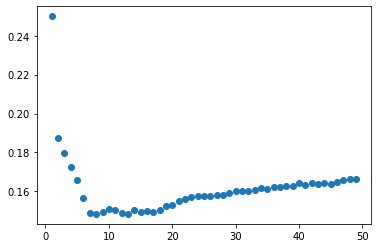

In [40]:
results = []
scaler = preprocessing.MinMaxScaler().fit(Xcm)
normXcm = scaler.fit_transform(Xcm)

for k in range(1, 50):
    ret = testPerformance(normXcm, y, "Knn", k)
    print(ret)
    results.append(ret)

results = np.array(results)
ks = range(1, 50)

plt.scatter(ks, results[:,0])

ind = np.argmin(results[:,0])
print(ks[ind])
print(results[ind])

(0.45103578154425616, 0.5423728813559322)
(0.26812029190207154, 0.7245762711864406)
(0.2075344437429192, 0.7627118644067796)
(0.18840616230497242, 0.7669491525423728)
(0.17397403036825002, 0.7838983050847458)
(0.17649043638124695, 0.7542372881355932)
(0.1617443487590078, 0.7754237288135594)
(0.1564000482043185, 0.7796610169491526)
(0.15138418824280753, 0.7838983050847458)
(0.15267149011301195, 0.7838983050847458)
(0.15192837387659416, 0.7966101694915254)
(0.14661269262374757, 0.8008474576271186)
(0.14662070774421, 0.8008474576271186)
(0.1517295721510519, 0.7754237288135594)
(0.14593905115738112, 0.7669491525423728)
(0.14670177363325107, 0.7627118644067796)
(0.14692355830732784, 0.7754237288135594)
(0.1480548568651876, 0.7754237288135594)
(0.1500692298258838, 0.7754237288135594)
(0.15513541482799834, 0.7711864406779662)
(0.15779464834443435, 0.788135593220339)
(0.15769676194677162, 0.7838983050847458)
(0.16004537029040808, 0.7711864406779662)
(0.16096906039106965, 0.7711864406779662)
(0

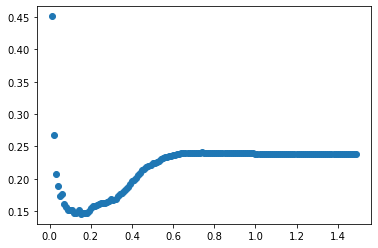

In [43]:
results = []
scaler = preprocessing.MinMaxScaler().fit(Xcm)
normXcm = scaler.fit_transform(Xcm)


for r in np.arange(0.01, 1.5, 0.01):
    ret = testPerformance(normXcm, y, "Rnn", r)
    print(ret)
    results.append(ret)

results = np.array(results)
ks = np.arange(0.01, 1.5, 0.01)

plt.scatter(ks, results[:,0])

ind = np.argmin(results[:,0])
print(ks[ind])
print(results[ind])


In [ ]:
print(testPerformance(Xcm, y, "includeAll"))
print(testPerformance(Xcm, y, "includeNone"))

(0.17588368554319705, 0.7584745762711864)
(0.1531231633791037, 0.7838983050847458)
(0.14736065493286768, 0.788135593220339)
(0.14485849408650073, 0.7923728813559322)
(0.14409085606871339, 0.7966101694915254)
(0.14604644357278657, 0.7796610169491526)
(0.14292724168983204, 0.7838983050847458)
(0.1428908443190663, 0.8008474576271186)
(0.1417632199201909, 0.7838983050847458)
(0.14593905115738112, 0.7669491525423728)
(0.1456066935902716, 0.7838983050847458)
(0.1448791250816518, 0.7838983050847458)
(0.1451651707565212, 0.7838983050847458)
(0.14468461695994833, 0.7838983050847458)
(0.1428886621192958, 0.7796610169491526)
(0.14231117031434407, 0.788135593220339)
(0.14114888287071392, 0.7838983050847458)
(0.1406767518973673, 0.7923728813559322)
(0.14119755728375957, 0.7923728813559322)
(0.14040388250647298, 0.8008474576271186)
(0.13905224947131123, 0.8008474576271186)
(0.1391620125532852, 0.809322033898305)
(0.13784751255365132, 0.8050847457627118)
(0.13716683752307682, 0.7966101694915254)
(0.1

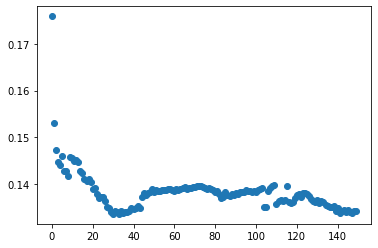

In [5]:

results = []
params = []
scaledXcm = np.copy(normXcm)

for scale in np.arange(0.1, 15.1, 0.1):
    scaledXcm[:,1] = scale*normXcm[:,1]
    bestr = 0
    mn = [10, 0]
    for r in np.arange(0.01, 1.5, 0.01):
        ret = testPerformance(Xcm, y, "Rnn", r)
        if mn[0] > ret[0]:
            bestr = r
            mn = ret
    params.append([scale, bestr])  
    results.append(mn)
    print(mn)
        

results = np.array(results)
ks = np.arange(len(results))

ind = np.argmin(results[:,0])

plt.scatter(ks, results[:,0])
print(params[ind])
print(results[ind])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
2
14
[0.1389819  0.83050847]


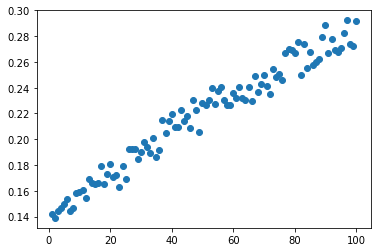

In [44]:
initBox()
results = []
indices = []
for i in range(1, 101):
    print(i)
    mn = [10, 0]
    bestj = 0
    for j in range(1, 101):
        ret = testPerformance(Xcm, y, "box", i, j)
        if mn[0] > ret[0]:
            bestj = j
            mn = ret
    results.append(mn)
    indices.append(bestj)

results = np.array(results)
xax = np.arange(1, 101)
plt.scatter(xax, results[:,0])

ind = np.argmin(results[:,0])
print(ind + 1)
print(indices[ind])
print(results[ind])



(0.5719837528833618, 0.4279661016949153)
(0.5031310390557021, 0.4957627118644068)
(0.43783771619733636, 0.559322033898305)
(0.3808973652123847, 0.614406779661017)
(0.35304218461804343, 0.6398305084745762)
(0.30311102340994633, 0.6864406779661016)
(0.2723792205898644, 0.711864406779661)
(0.24521742002904048, 0.7372881355932204)
(0.20716867053885876, 0.7754237288135594)
(0.20586304082545046, 0.7754237288135594)
(0.1802586447238093, 0.8008474576271186)
(0.18170061833390033, 0.7966101694915254)
(0.1815775609705357, 0.7966101694915254)
(0.17798949108896064, 0.7966101694915254)
(0.18410625553529444, 0.788135593220339)
(0.18435056014423873, 0.7838983050847458)
(0.18056472444709656, 0.788135593220339)
(0.18523308194012875, 0.7754237288135594)
(0.17656288788947191, 0.7796610169491526)
(0.18207002394165142, 0.7711864406779662)
(0.19072550362535062, 0.7542372881355932)
(0.19754387571070722, 0.7415254237288136)
(0.19363279966195598, 0.7457627118644068)
(0.1932919004713382, 0.7457627118644068)
(0.1

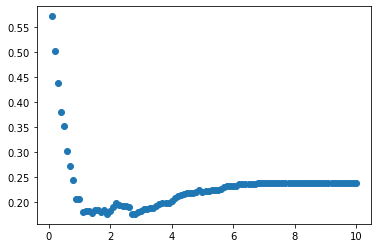

In [10]:
results = []
for k in np.arange(0.1, 10.1, 0.1):
    ret = testPerformance(Xcm, y, "sigmaCut", k)
    print(ret)
    results.append(ret)

results = np.array(results)
ks = np.arange(0.1, 10.1, 0.1)

plt.scatter(ks, results[:,0])

In [38]:
print(testPerformance(Xcm, y, "logistic"))

print(testPerformance(Xall, y, "logistic"))

print(testPerformance(Xcm, y, "SVM"))

(0.18737404080577952, 0.7372881355932204)
(0.18499731383728873, 0.7372881355932204)
(0.18618853506044272, 0.7330508474576272)


In [15]:
print(testPerformance(Xall, y, "neuralNetwork"))

C:\Users\Jackson Lee\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


(0.23279290390283522, 0.6313559322033898)
